In [ ]:
# new script for generating the non-Gaussian tables (2024/05/02)
# the new version uses panda dataframes and organizes a few blocks into one to make the code cleaner

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [200]:
instrument = 'amsua'
channel    = 'ch21'
stdev_from = 'OmF'
expid      = 'full_clr_cld'
#expid      = 'create_table'
#expid      = 'ng_v0'
predictor  = 'sym_cld'

In [201]:
### (tuning) parameters for constructing the non-Gaussian tables

def nonGaussian_params(instrument, channel, predictor):
    
    # cloud predictor bins def:
    if predictor in ('obs_cld','sym_cld'):
        if instrument == 'amsua':
            if channel in ('ch1','ch2','ch3','ch4'):
                cloud_edge = np.array([0.00, 0.03, \
                                       0.06, 0.10, \
                                       0.15, 0.20, \
                                       0.25, 0.30, \
                                       0.35, 1.00 ])
            elif channel in ('ch5'):
                cloud_edge = np.array([0.00, 0.03, \
                                       0.06, 0.10, \
                                       0.15, 0.20, \
                                       0.25, 0.30, \
                                       0.35, 0.40, 1.00])
            elif channel in ('ch15'):
                cloud_edge = np.array([0.00, 0.03, \
                                       0.06, 0.10, \
                                       0.15, 0.20, \
                                       0.25, 1.00])
        elif instrument == 'atms':
            if channel in ('ch1','ch2','ch3','ch4','ch5','ch16'):
                cloud_edge = np.array([0.00, 0.03, \
                                       0.06, 0.10, \
                                       0.15, 0.20, \
                                       0.25, 0.30, \
                                       0.35, 1.00 ]) 
            elif channel in ('ch6','ch18'):
                cloud_edge = np.array([0.00, 0.03, \
                                       0.06, 0.10, \
                                       0.15, 0.20, \
                                       0.25, 0.30, \
                                       0.35, 0.40, \
                                       0.45, 1.00])
            elif channel in ('ch17'):
                cloud_edge = np.array([0.00, 0.03, \
                                       0.06, 0.10, \
                                       0.15, 0.20, \
                                       0.25, 0.30, 1.00])
            elif channel in ('ch19','ch20','ch21','ch22'):
                cloud_edge = np.array([0.00, 0.03, \
                                       0.06, 0.10, \
                                       0.15, 0.20, \
                                       0.25, 0.30, \
                                       0.35, 0.40, \
                                       0.55, 1.00])

    elif predictor == 'no_predictor':
        cloud_edge = np.array([0.00, 1.00])

    
    # regrid pdf range:
    if predictor in ('sym_cld', 'obs_cld'):
        if instrument == 'amsua':
            if channel in ('ch1','ch2','ch15'):
                bdy_regrid = 60
                dx_regrid  = 0.1
            elif channel in ('ch3'):
                bdy_regrid = 40
                dx_regrid  = 0.1        
            elif channel in ('ch4'):
                bdy_regrid = 15 
                dx_regrid  = 0.05
            elif channel in ('ch5'):
                bdy_regrid = 5
                dx_regrid  = 0.01

        if instrument == 'atms':
            if channel in ('ch1','ch2','ch16'):
                bdy_regrid = 60
                dx_regrid  = 0.1
            elif channel in ('ch3'):
                bdy_regrid = 40
                dx_regrid  = 0.1
            elif channel in ('ch4','ch17','ch18','ch19','ch20','ch21'):
                bdy_regrid = 20 
                dx_regrid  = 0.05
            elif channel in ('ch22'):
                bdy_regrid = 30
                dx_regrid  = 0.05
            elif channel in ('ch5'):
                bdy_regrid = 8
                dx_regrid  = 0.01
            elif channel in ('ch6'):
                bdy_regrid = 5
                dx_regrid  = 0.01

    elif predictor in ('no_predictor'):
        if instrument == 'amsua':
            if channel in ('ch1','ch2','ch15'):
                bdy_regrid = 60
                dx_regrid  = 0.1
            elif channel in ('ch3'):
                bdy_regrid = 40
                dx_regrid  = 0.1        
            elif channel in ('ch4'):
                bdy_regrid = 15 
                dx_regrid  = 0.05
            elif channel in ('ch5'):
                bdy_regrid = 5
                dx_regrid  = 0.01    
        if instrument == 'atms':
            if channel in ('ch1','ch2','ch16'):
                bdy_regrid = 60
                dx_regrid  = 0.1
            elif channel in ('ch3'):
                bdy_regrid = 40
                dx_regrid  = 0.1
            elif channel in ('ch4','ch17','ch18','ch19','ch20','ch21','ch22'):
                bdy_regrid = 20 
                dx_regrid  = 0.05
            elif channel in ('ch5'):
                bdy_regrid = 8
                dx_regrid  = 0.01
            elif channel in ('ch6'):
                bdy_regrid = 5
                dx_regrid  = 0.01
                
    min_allow_pdf = 2.5e-4
    max_allowed_stdev = 100
    
    # fitted polynomial order
    if predictor in ['obs_cld', 'sym_cld']:
        if instrument == 'amsua':
            if channel in ('ch1','ch2','ch3','ch4','ch15'):
                poly_dim = 8
            elif channel in ('ch5'):
                poly_dim = 8

        if instrument == 'atms':
            if channel in ('ch1','ch2','ch3','ch4','ch5','ch6','ch16'):
                poly_dim = 8
            elif channel in ('ch17','ch18'):
                poly_dim = 16
            elif channel in ('ch19','ch20','ch21','ch22'):
                poly_dim = 12
    
    elif predictor in ['no_predictor']:
        if instrument == 'amsua':
            if channel in ('ch1','ch2','ch3','ch4','ch5','ch15'):
                poly_dim = 16
        if instrument == 'atms':
            if channel in ('ch1','ch2','ch3','ch4','ch5','ch6','ch19','ch20','ch21','ch22'):
                poly_dim = 16
            elif channel in ('ch16','ch17','ch18'):
                poly_dim = 20
                
    # parameters for defining the tails
    if predictor in ('obs_cld','sym_cld'):
        if instrument == 'amsua':
            if channel in ('ch1','ch2','ch3','ch4','ch15'):
                critical_cost_val = 6.5
                extrap_slope      = 0.5 
            elif channel in ('ch5'):
                critical_cost_val = 6.5
                extrap_slope      = 0.5 

        if instrument == 'atms':
            if channel in ('ch1','ch2','ch3','ch4','ch5','ch6','ch16','ch17','ch18','ch19','ch20','ch21','ch22'):
                critical_cost_val = 6.5
                extrap_slope      = 0.5 

    elif predictor in ('no_predictor'):
        if instrument == 'amsua':
            if channel in ('ch1','ch2','ch3','ch4','ch5','ch15'):
                critical_cost_val = 7.0
                extrap_slope      = 0.5 
        if instrument == 'atms':
            if channel in ('ch1','ch2','ch3','ch4','ch5','ch6','ch16','ch17','ch18','ch19','ch20','ch21','ch22'):
                critical_cost_val = 7.0
                extrap_slope      = 0.5 
                
    # low-resolution output:
    if predictor in ('sym_cld','obs_cld'):
        if instrument == 'amsua':
            if channel in ('ch1','ch2','ch3','ch5','ch15'):
                coarse_ratio  = 20
            elif channel in ('ch4'):
                coarse_ratio  = 10

        if instrument == 'atms':
            if channel in ('ch1','ch2','ch3','ch4','ch5','ch6','ch16','ch22'):
                coarse_ratio  = 20
            elif channel in ('ch17','ch18','ch19','ch20','ch21'):
                coarse_ratio  = 10

    elif predictor in ('no_predictor'):
        if instrument == 'amsua':
            if channel in ('ch1','ch2','ch3','ch5','ch15'):
                coarse_ratio  = 10
            elif channel in ('ch4'):
                coarse_ratio  = 5
        if instrument == 'atms':
            if channel in ('ch1','ch2','ch3','ch4','ch5','ch6','ch16','ch22'):
                coarse_ratio  = 10
            elif channel in ('ch17','ch18','ch19','ch20','ch21'):
                coarse_ratio  = 5

    return cloud_edge, bdy_regrid, dx_regrid, min_allow_pdf, poly_dim, critical_cost_val, extrap_slope, max_allowed_stdev, coarse_ratio

In [202]:
### read omf csv:
if expid == 'create_table':
    fn = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/compile_radstats/csv_files/default_used_to_build_pdfs/omf_stats_{instrument}_{channel}.csv'
else:
    fn = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/compile_radstats/csv_files/{expid}/omf_stats_{instrument}_{channel}.csv'
df = pd.read_csv(fn)

# screen the data:
dfs = df[abs(df['omf_ges']) < 1e3]

In [203]:
### sort the data based on regions
regions=['sea']
lats   =['Global']

#regions=['land','sea']
#lats   =['Global','90S-60S','60S-40S','40S-20S','20S-0','0-20N','20N-40N','40N-60N','60N-90N']

adf={} # "a"nalysis "d"ata "f"rame

for rg in regions:
    adf[rg] = {}  # Initialize the nested dictionary for each experiment
    if rg == 'land':
        dftmp = dfs.loc[ dfs['fland']>=0.99 ]
    elif rg == 'sea':
        dftmp = dfs.loc[ dfs['fwater']>=0.99 ]
        
    for lat in lats:
        if lat == 'Global':
            adf[rg][lat] = dftmp
        elif lat == '90S-60S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-60) & (dftmp['lat']>-90) ]
        elif lat == '60S-40S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-40) & (dftmp['lat']>-60) ]
        elif lat == '40S-20S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-20) & (dftmp['lat']>-40) ]
        elif lat == '20S-0':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=0) & (dftmp['lat']>-20) ]
        elif lat == '0-20N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=20) & (dftmp['lat']>0) ]
        elif lat == '20N-40N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=40) & (dftmp['lat']>20) ]
        elif lat == '40N-60N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=60) & (dftmp['lat']>40) ]
        elif lat == '60N-90N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=90) & (dftmp['lat']>60) ]

In [204]:
### generate the non-Gaussian tables (derived from the joint PDFs)

cloud_edge, bdy_regrid, dx_regrid, min_allow_pdf, poly_dim, critical_cost_val, extrap_slope, max_allowed_stdev, coarse_ratio = \
          nonGaussian_params(instrument, channel, 'sym_cld')

dftmp = adf['sea']['Global']
n_cat = len(cloud_edge)-1

nginfo = {}; # dictionary for storing all the non-Gaussian information
for i in range(n_cat):
    print("processing the ",i+1,"-th cloud bin...")
    nginfo[i] = {} # initialize the nested dictionary
    catdf = dftmp.loc[ ( 0.5*(dftmp['clw_obs']+dftmp['clw_bg_ges']) >= cloud_edge[i]   )& \
                       ( 0.5*(dftmp['clw_obs']+dftmp['clw_bg_ges']) <  cloud_edge[i+1] )]  # "cat"-egory dataframe

    # === save some basic statistics:
    ndata = catdf.shape[0]
    nginfo[i]['count'] = ndata
    nginfo[i]['mean']  = catdf['omf_ges'].mean()
    nginfo[i]['stdev'] = catdf['omf_ges'].std()
    
    # cloud marginal pdfs
    axis_cloud = np.arange(-1,1+0.1, 0.05)
    hist_obs_cld, _  = np.histogram(catdf['clw_obs'], bins=axis_cloud, density=True)
    hist_bkg_cld, _  = np.histogram(catdf['clw_bg_ges'] , bins=axis_cloud, density=True)
    hist_diff_cld, _ = np.histogram(catdf['clw_obs'] - catdf['clw_bg_ges'], bins=axis_cloud, density=True)
    
    # === save the cloud PDF info:
    nginfo[i]['axis_cloud'] = 0.5*( axis_cloud[1:] + axis_cloud[:-1])
    nginfo[i]['hist_obs_cld'] = hist_obs_cld
    nginfo[i]['hist_bkg_cld'] = hist_bkg_cld
    nginfo[i]['hist_diff_cld'] = hist_diff_cld

    # omf marginal pdfs:
    # need to define the x-axis for the histogram of omf (each cat is different)
    q1 = catdf['omf_ges'].quantile(0.25)
    q3 = catdf['omf_ges'].quantile(0.75)
    dx_tmp = 2*(q3-q1)/ndata**(1/3)
    
    inflation = 3
    domf_init = 0.05 # a first-guess d(omf)
    dx_omf = np.ceil(inflation*dx_tmp/domf_init)*domf_init
    
    # determine the max/min value based on the above dx_omf
    max_val = ( np.ceil(max(catdf['omf_ges'])/dx_omf)+5)*dx_omf
    min_val = (np.floor(min(catdf['omf_ges'])/dx_omf)-5)*dx_omf
    axis_omf = np.arange(min_val, max_val+dx_omf, dx_omf)
    
    # generate the histogram
    hist_omf, _ = np.histogram(catdf['omf_ges'], bins=axis_omf, density=True)
    
    # regrid the pdfs onto the same grid 
    regrid = np.arange(-bdy_regrid, bdy_regrid+dx_regrid, dx_regrid)

    xp = 0.5*( axis_omf[1:] + axis_omf[:-1])
    yp = hist_omf
    hist_regrid = np.interp(regrid, xp, yp)

    # also calculate the cost-function:
    tmp0 = hist_regrid.copy()       # very important to copy the array here, otherwise the next line will replace the values in hist_omf_regrid_cat
    tmp0[np.where(tmp0<=min_allow_pdf)] = 0.0
    cost_fn = -np.log(tmp0)
    cost_fn[np.isinf(cost_fn)] = np.nan
    
    # === save the cloud PDF info:
    nginfo[i]['critical_cost_val'] = critical_cost_val
    nginfo[i]['cloud_edge'] = cloud_edge[i:i+2]
    nginfo[i]['dx_omf'] = dx_regrid
    nginfo[i]['axis_omf'] = regrid
    nginfo[i]['hist_omf'] = hist_regrid
    nginfo[i]['cost_fn']  = cost_fn

processing the  1 -th cloud bin...


/tmp/ipykernel_2063798/3422590177.py:62: RuntimeWarning: divide by zero encountered in log
  cost_fn = -np.log(tmp0)


processing the  2 -th cloud bin...


/tmp/ipykernel_2063798/3422590177.py:62: RuntimeWarning: divide by zero encountered in log
  cost_fn = -np.log(tmp0)


processing the  3 -th cloud bin...


/tmp/ipykernel_2063798/3422590177.py:62: RuntimeWarning: divide by zero encountered in log
  cost_fn = -np.log(tmp0)


processing the  4 -th cloud bin...


/tmp/ipykernel_2063798/3422590177.py:62: RuntimeWarning: divide by zero encountered in log
  cost_fn = -np.log(tmp0)
/tmp/ipykernel_2063798/3422590177.py:62: RuntimeWarning: divide by zero encountered in log
  cost_fn = -np.log(tmp0)
/tmp/ipykernel_2063798/3422590177.py:62: RuntimeWarning: divide by zero encountered in log
  cost_fn = -np.log(tmp0)
/tmp/ipykernel_2063798/3422590177.py:62: RuntimeWarning: divide by zero encountered in log
  cost_fn = -np.log(tmp0)


processing the  5 -th cloud bin...
processing the  6 -th cloud bin...
processing the  7 -th cloud bin...
processing the  8 -th cloud bin...
processing the  9 -th cloud bin...
processing the  10 -th cloud bin...
processing the  11 -th cloud bin...


/tmp/ipykernel_2063798/3422590177.py:62: RuntimeWarning: divide by zero encountered in log
  cost_fn = -np.log(tmp0)
/tmp/ipykernel_2063798/3422590177.py:62: RuntimeWarning: divide by zero encountered in log
  cost_fn = -np.log(tmp0)
/tmp/ipykernel_2063798/3422590177.py:62: RuntimeWarning: divide by zero encountered in log
  cost_fn = -np.log(tmp0)
/tmp/ipykernel_2063798/3422590177.py:62: RuntimeWarning: divide by zero encountered in log
  cost_fn = -np.log(tmp0)


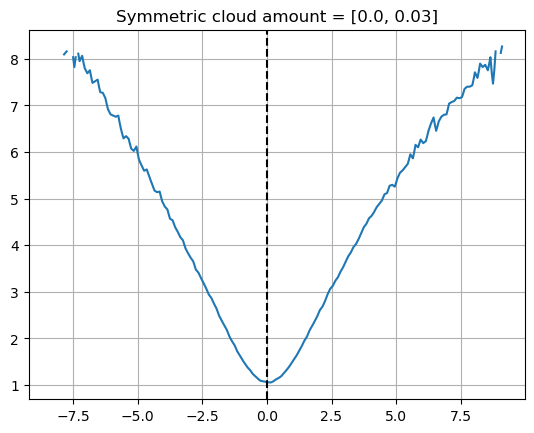

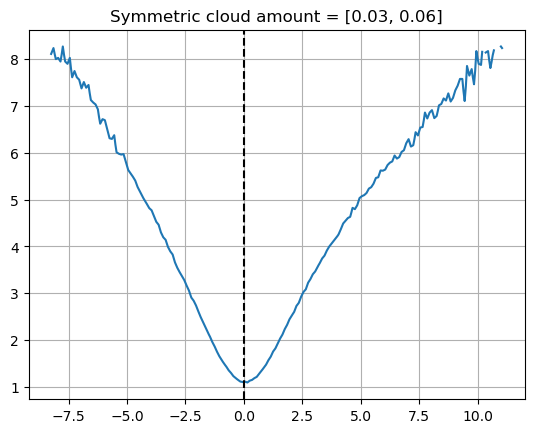

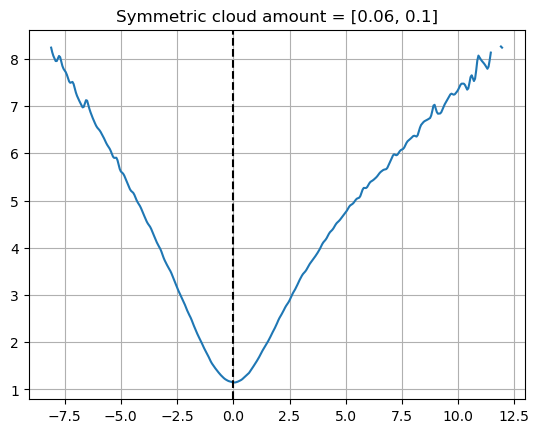

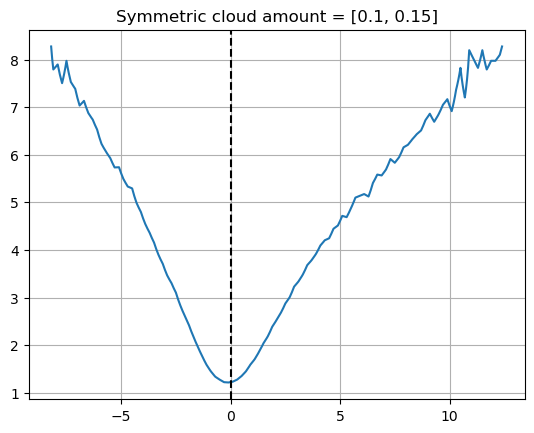

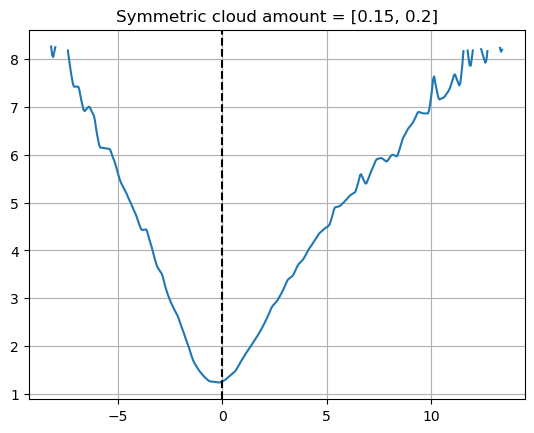

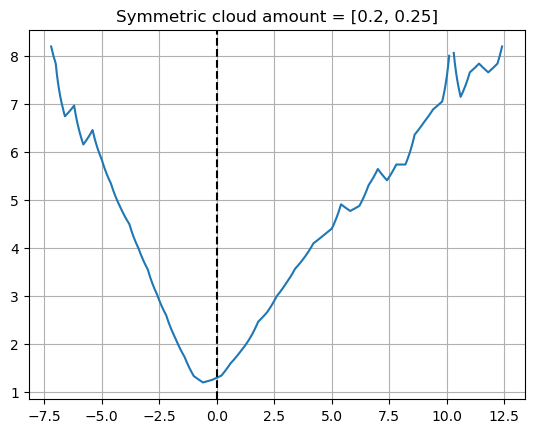

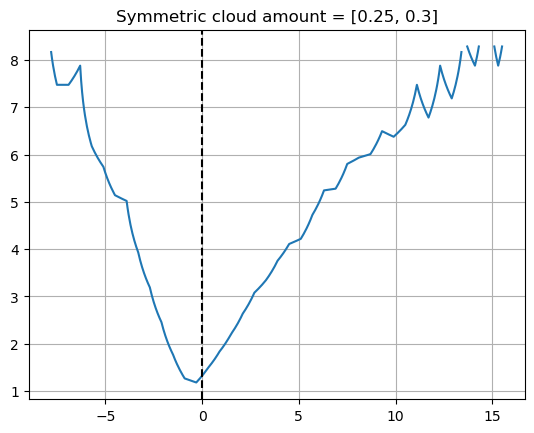

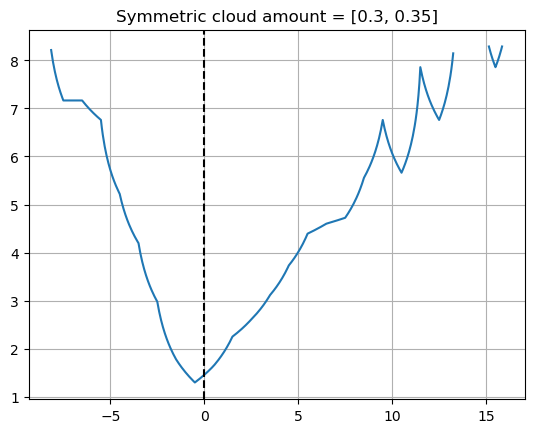

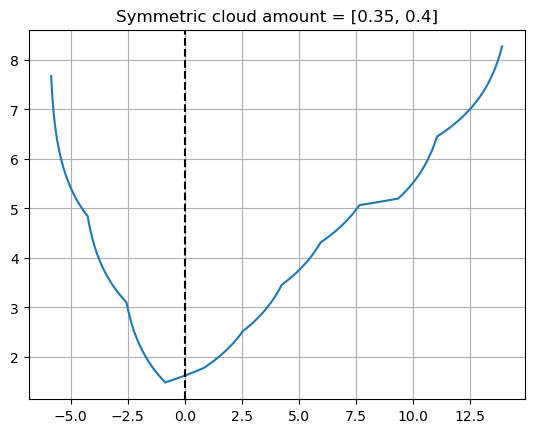

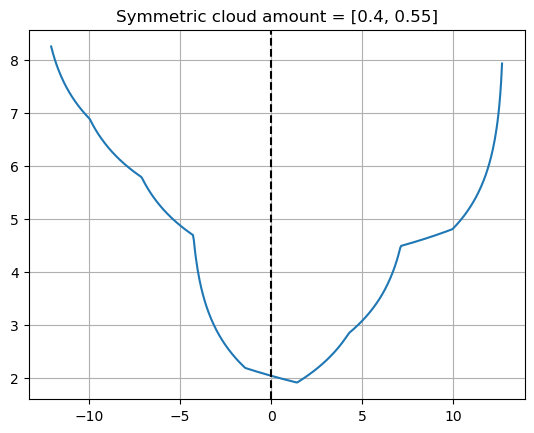

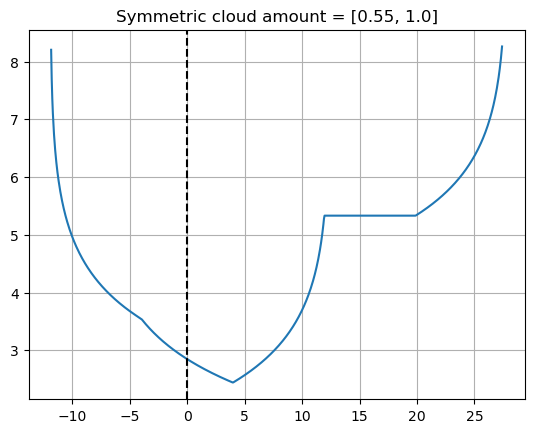

In [205]:
# check if the regrid pdfs look ok:
for i in range(n_cat):
    plt.plot(regrid, nginfo[i]['cost_fn'])
    plt.axvline(x=0, color='black', linestyle='--', label='Vertical Line at x=0')
    #plt.xlim([-70,70])
    plt.grid(True)
    plt.title(f'Symmetric cloud amount = [{cloud_edge[i]}, {cloud_edge[i+1]}]')
    plt.show()   

In [206]:
### Polynomial fit to the cost-functions

# Define the polynomial function
def poly_func(x, *coefficients):
    return np.polyval(coefficients[::-1], x)

# Fit a polynomial with a positive constant term
initial_guess = np.ones(poly_dim+1)  # Adjust the length based on the polynomial degree
bounds = (np.full(poly_dim+1, -np.inf), np.full(poly_dim+1, np.inf))  
#bounds[0][-1] = 0

fitted_cost_fn = []
fitted_coeff   = []
for i in range(n_cat):
    valid_idx = ~np.isnan(nginfo[i]['cost_fn'])
    coefficients, covariance = curve_fit(poly_func, nginfo[i]['axis_omf'][valid_idx], nginfo[i]['cost_fn'][valid_idx], p0=initial_guess, bounds=bounds)
    tmp = poly_func(regrid, *coefficients)
    tmp[~valid_idx] = np.nan  
    nginfo[i]['fitted_cost_fn'] = tmp
    nginfo[i]['fitted_coeff'] = coefficients

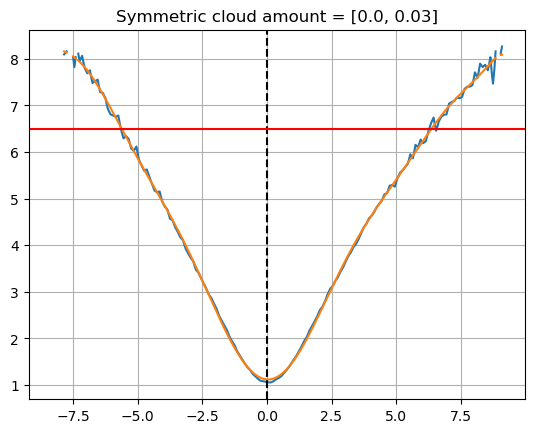

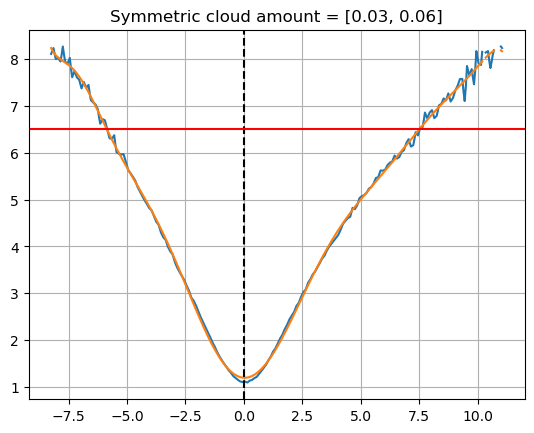

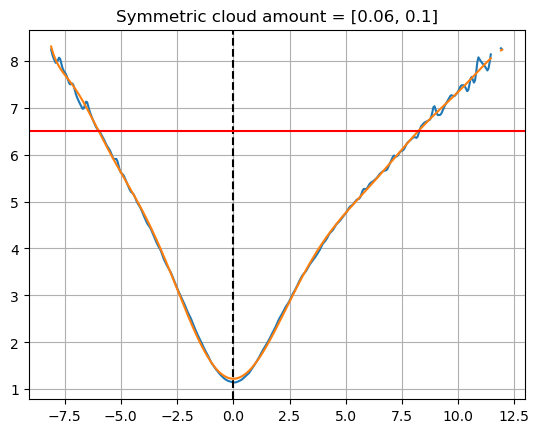

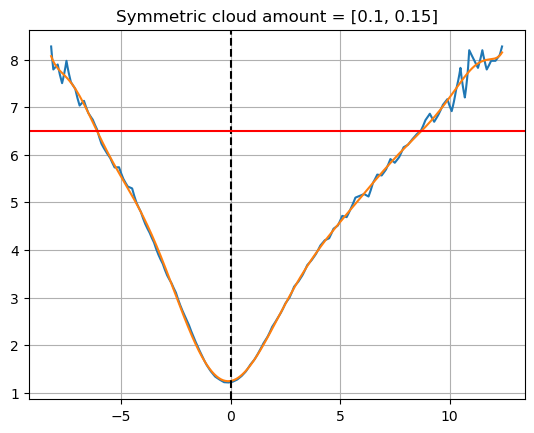

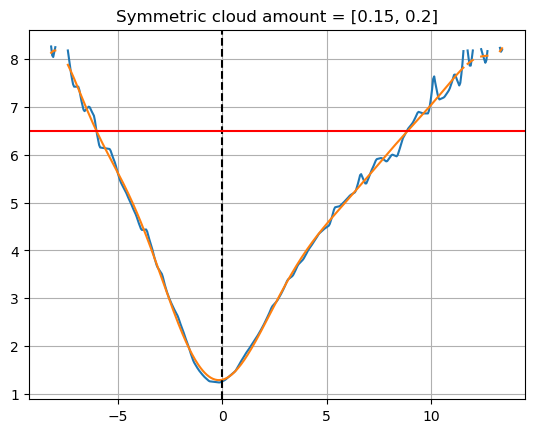

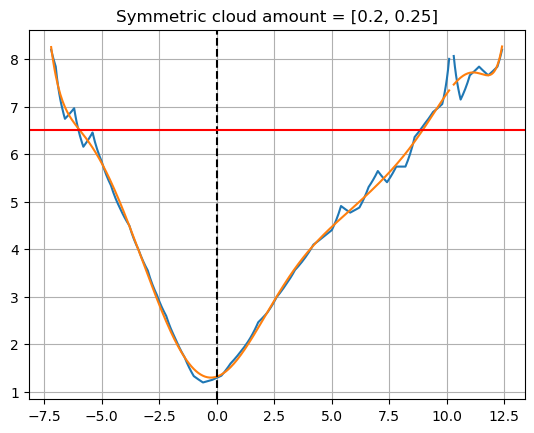

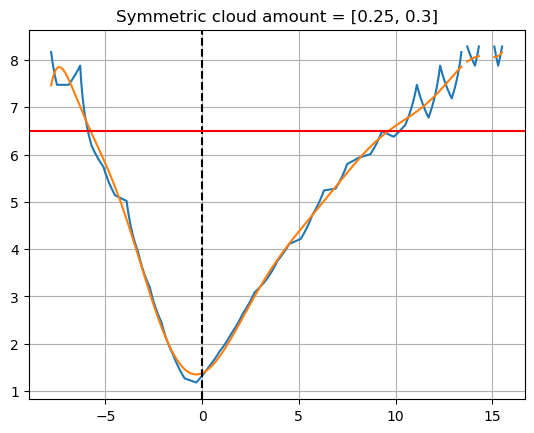

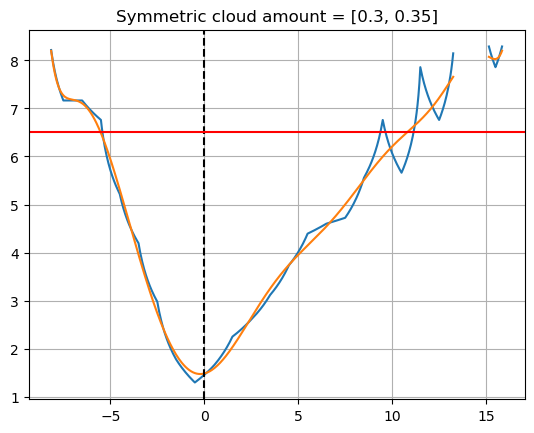

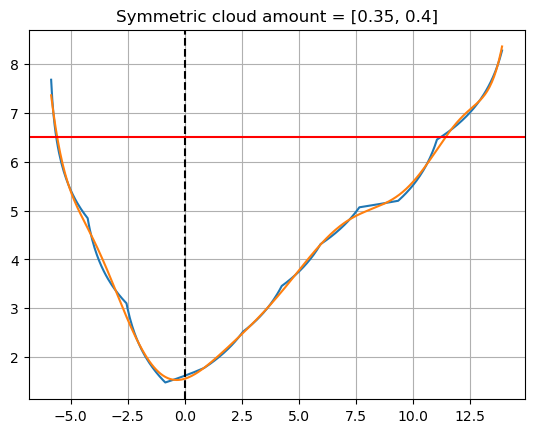

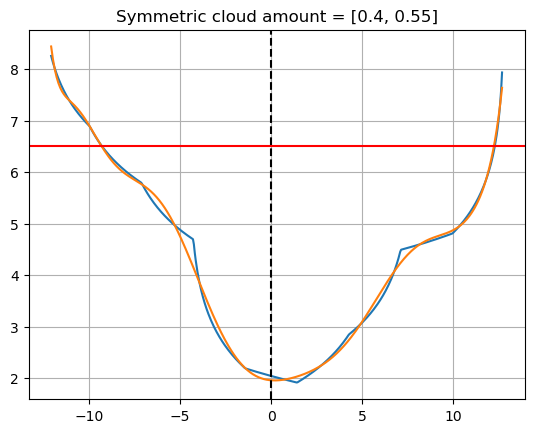

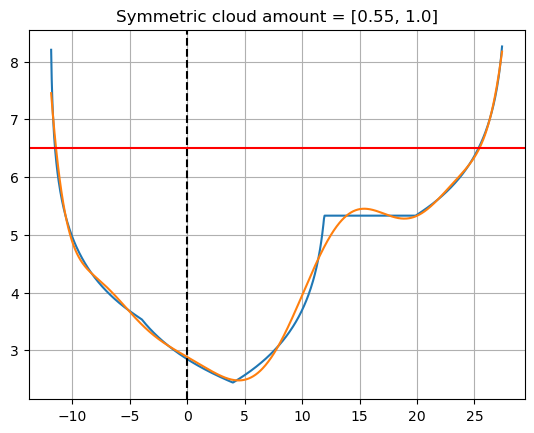

In [207]:
# check if the fitted cost-functions are valid:
for i in range(n_cat):
    plt.plot(regrid, nginfo[i]['cost_fn'])
    plt.plot(regrid, nginfo[i]['fitted_cost_fn'])
    plt.axvline(x=0, color='black', linestyle='--', label='Vertical Line at x=0')
    plt.axhline(y=critical_cost_val, color='red')
    #plt.xlim([-70,70])
    plt.grid(True)
    plt.title(f'Symmetric cloud amount = [{cloud_edge[i]}, {cloud_edge[i+1]}]')
    plt.show()  


In [208]:
### identify the mode 
# identify the 'average' mode from regridded pdf (should be the same as the original histogram)

def find_intersections(x_values, y_values):
    # Find indices where y_values change sign (cross y=0)
    sign_changes = np.where(np.diff(np.sign(y_values)))[0]

    # Interpolate to find x-values at sign changes
    x_intersections = np.interp(0, y_values[sign_changes], x_values[sign_changes])

    return x_intersections


for i in range(n_cat):
    fg_top_indices = np.argsort(nginfo[i]['hist_omf'])[-1:]  # used as a first-guess
    min_value      = np.sort(nginfo[i]['fitted_cost_fn'][int(fg_top_indices-80):int(fg_top_indices+80)])[0]    
    min_value_idx  = np.where(nginfo[i]['fitted_cost_fn'] == min_value)
    mode_value     = nginfo[i]['axis_omf'][min_value_idx]
    #top_indices    = np.argsort(fitted_cost_fn[i])[:num_avg_pts]
    #avg_idx_of_top = np.mean(regrid[top_indices]) 
    
    nginfo[i]['mode']     = mode_value
    nginfo[i]['mode_idx'] = find_intersections(np.arange(0,len(nginfo[i]['axis_omf'])), nginfo[i]['axis_omf']-mode_value)

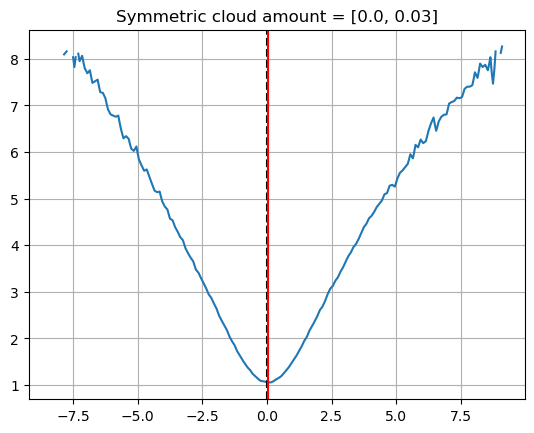

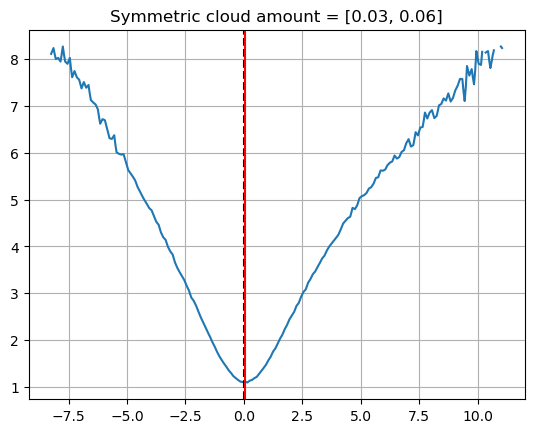

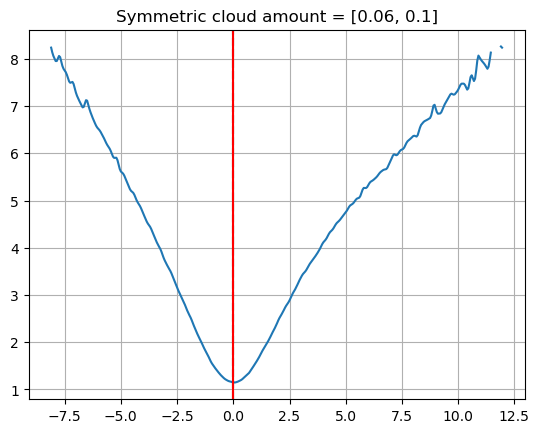

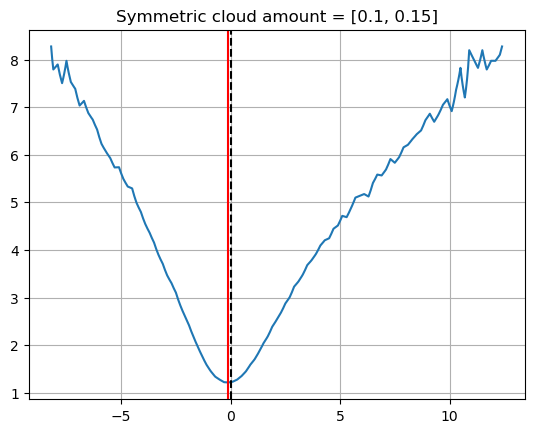

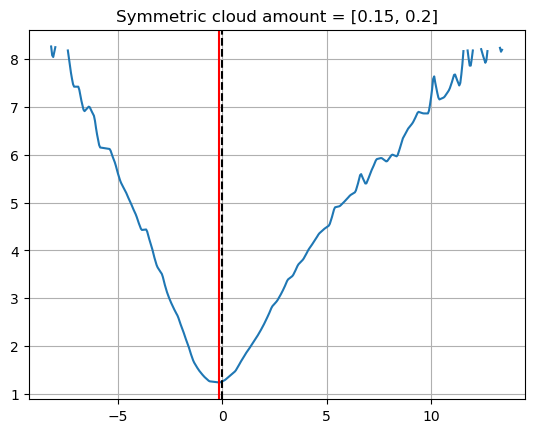

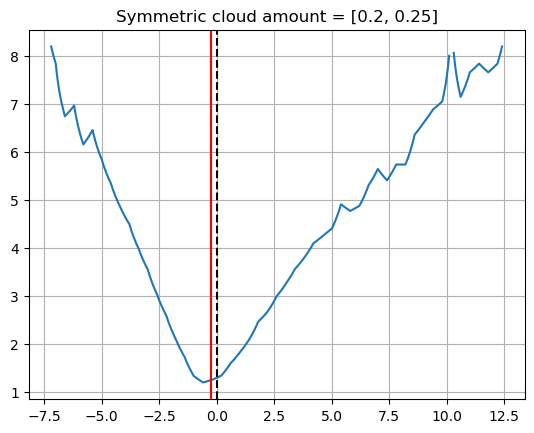

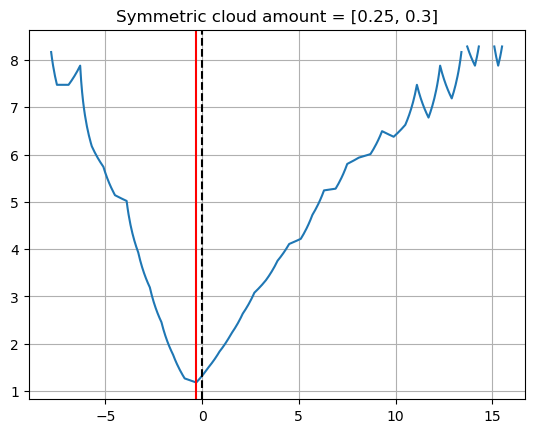

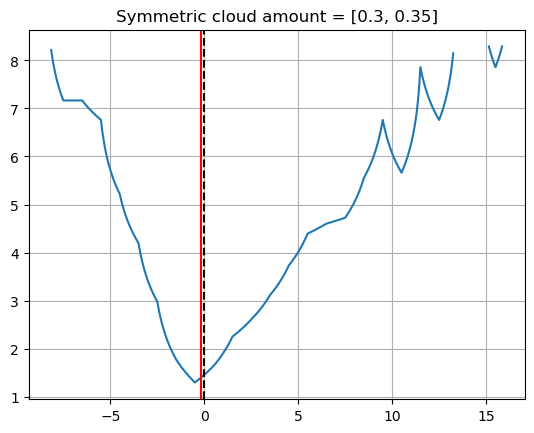

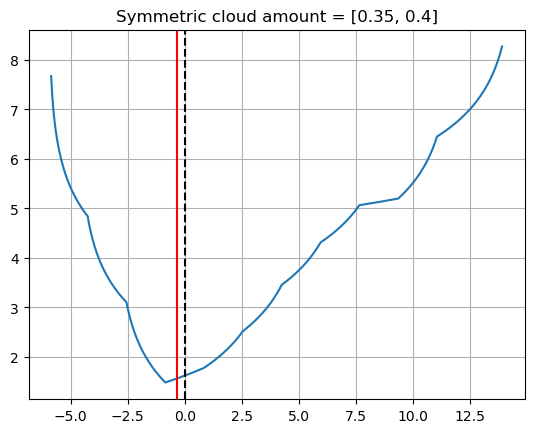

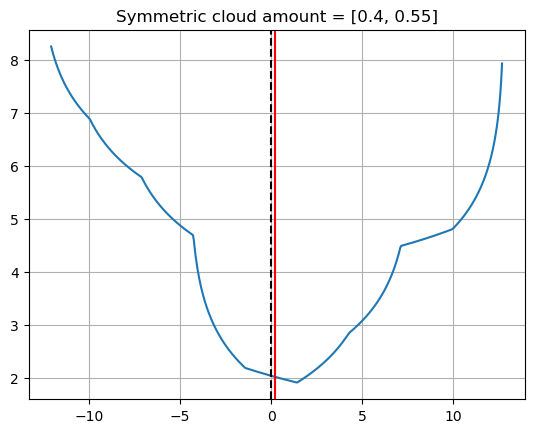

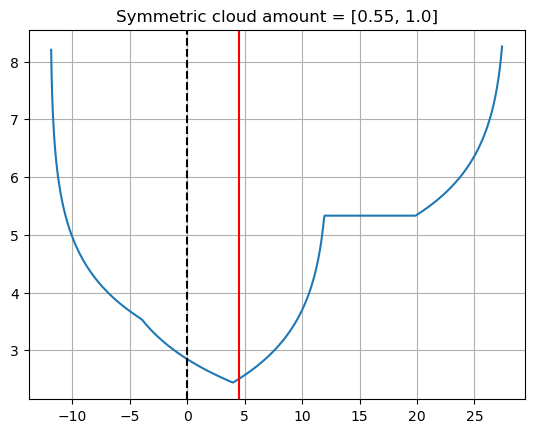

In [209]:
# check if the mode is valid

for i in range(n_cat):
    plt.plot(regrid, nginfo[i]['cost_fn'])
    plt.axvline(x=0, color='black', linestyle='--', label='Vertical Line at x=0')
    plt.axvline(nginfo[i]['mode'], color='red')
    #plt.xlim([-70,70])
    plt.grid(True)
    plt.title(f'Symmetric cloud amount = [{cloud_edge[i]}, {cloud_edge[i+1]}]')
    plt.show()  

In [210]:
### estimate the standard deivation grid-by-grid -- hybrid method (new method: 2023/11/20)
# when far away from the mode, try to derive the analytical solution
# when close to the mode (or to the boundary), use regression method

# Define derivative of a polynomial:
# note that the input coefficients is from low order to high order [a0, a1, a2,...,an]
# while the final_coeff is from high order to low order [a0, a1, a2,...,an]
def local_derivative(x, coefficients):
    tmp = coefficients.copy()
    new_coeff   = tmp[-1:0:-1]
    final_coeff = new_coeff*np.arange(len(coefficients)-1,0,-1)
    return np.polyval(final_coeff, x)


estimate_sig_cat = []

# parameters for regression method:
regression_range    = 1.5     # when |x-mode|<regression_range
width               = 10       # how many points are used to do the quadratic-regression
min_regress_samples = 10       # the minimum number of samples used in the regression 

for i in range(n_cat):
    len_axis = len(nginfo[i]['axis_omf'])
    estimate_sig = np.zeros(len_axis) # a dummy vector
    nonGaussian_slope=np.zeros(len_axis)
    
    for j in range(len_axis):
        if np.isnan(nginfo[i]['fitted_cost_fn'][j]):
            estimate_sig[j] = np.nan
            
        elif np.abs(nginfo[i]['axis_omf'][j] - nginfo[i]['mode']) < regression_range: # when close to the mode: regression method
            data_use_idx = np.arange(j-width, j+width)
            sample_x = nginfo[i]['axis_omf'][data_use_idx] - nginfo[i]['mode']
            #sample_y = cost_fn[j][data_use_idx]
            sample_y = nginfo[i]['fitted_cost_fn'][data_use_idx]
            y_is_nan = np.isnan(sample_y)
        
            if sum(y_is_nan) > len(sample_y) - min_regress_samples:
                estimate_sig[j] = np.nan
            else:
                p = np.polyfit(np.square(sample_x[~y_is_nan]), sample_y[~y_is_nan], 1)
            
                if p[0]<0:
                    estimate_sig[j] = np.nan
                else:
                    estimate_sig[j] = np.sqrt(1/(2*p[0]))
               
        #elif fitted_cost_fn[j][i] > 8: 
        #    estimate_sig[i] = np.nan
        else: # otherwise use the analytical solution of the fitted polynomial:
            nonGaussian_slope = local_derivative(nginfo[i]['axis_omf'][j], nginfo[i]['fitted_coeff'])
            temp_val = (nginfo[i]['axis_omf'][j] - nginfo[i]['mode'])/nonGaussian_slope
            if temp_val < 0:
                estimate_sig[j] = estimate_sig[j-1]
            else:
                estimate_sig[j] = np.minimum(np.sqrt(temp_val), max_allowed_stdev)
        #end if
    #end for
    
    # record the estimated standard deviation, get rid of noisy data, and also extrapolate for the tails
    # critical_cost_val: if the cost function value < critical val, then kick out
    # extrap_slope: the slope to extrapolate the standard deviations for the tails of the distribution
    range_min_idx = np.where(nginfo[i]['fitted_cost_fn']<critical_cost_val)[0][0]   # the index of the left bdy
    range_max_idx = np.where(nginfo[i]['fitted_cost_fn']<critical_cost_val)[0][-1]  # the index of the right bdy
    
    record_tmp = np.zeros(len_axis) # a dummy vector
    for j in range(len_axis):
        if j<=range_min_idx:
            record_tmp[j] = -extrap_slope * (nginfo[i]['axis_omf'][j] - nginfo[i]['axis_omf'][range_min_idx]) + estimate_sig[range_min_idx]
        elif j>=range_max_idx:
            record_tmp[j] = extrap_slope  * (nginfo[i]['axis_omf'][j] - nginfo[i]['axis_omf'][range_max_idx]) + estimate_sig[range_max_idx]        
        else:
            record_tmp[j] = estimate_sig[j]
            
    # interpolate to get rid of nan values
    valid_idx = ~np.isnan(record_tmp)
    interp_function = interp1d(nginfo[i]['axis_omf'][valid_idx], record_tmp[valid_idx], kind='linear', fill_value='extrapolate')
        
    nginfo[i]['range_min_idx'] = range_min_idx
    nginfo[i]['range_max_idx'] = range_max_idx
    nginfo[i]['estimate_sig']  = estimate_sig
    nginfo[i]['record_sig']    = interp_function(nginfo[i]['axis_omf'])

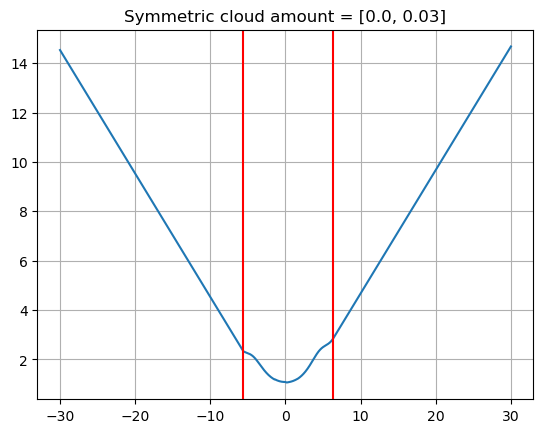

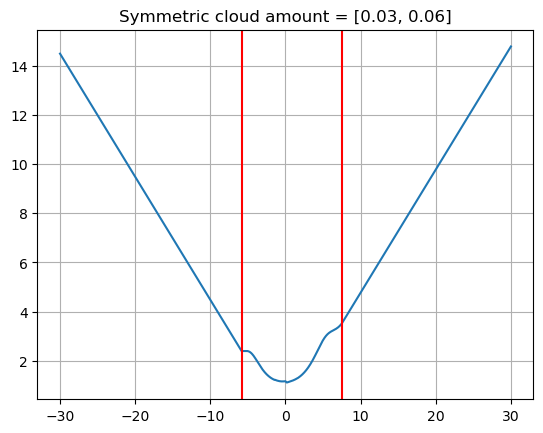

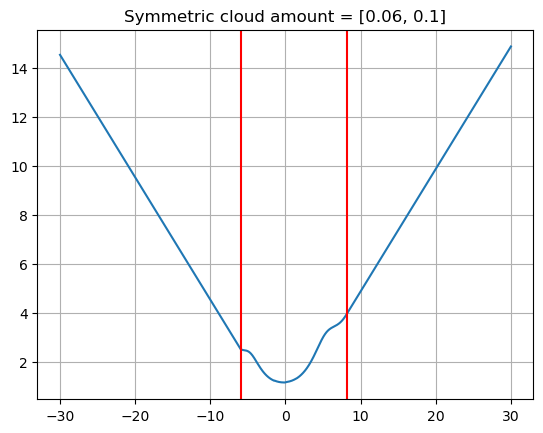

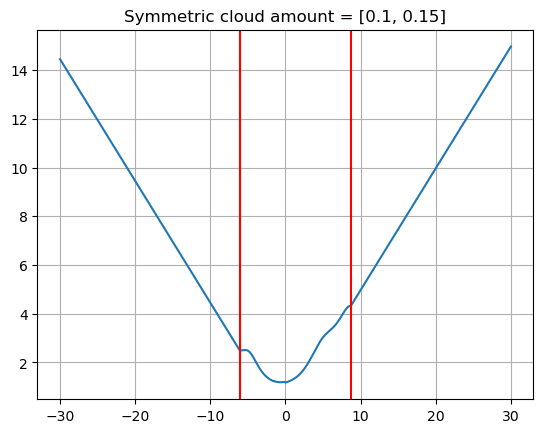

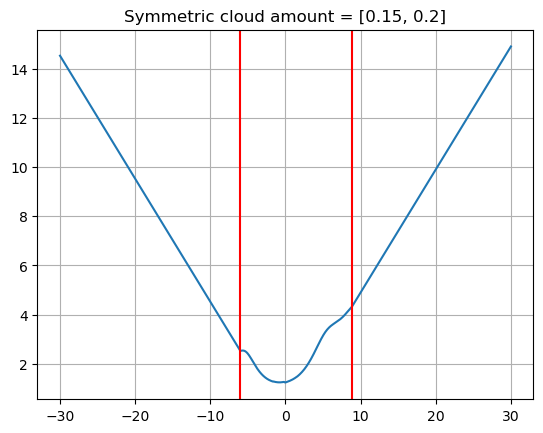

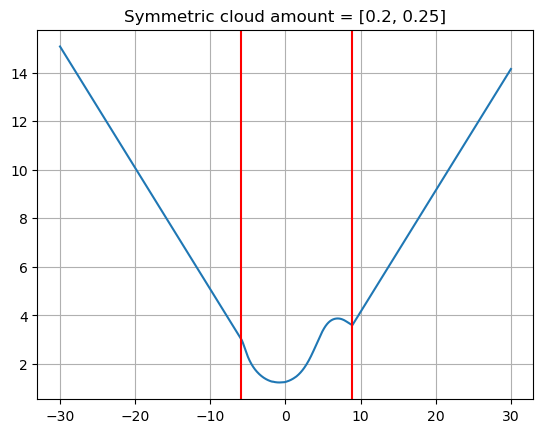

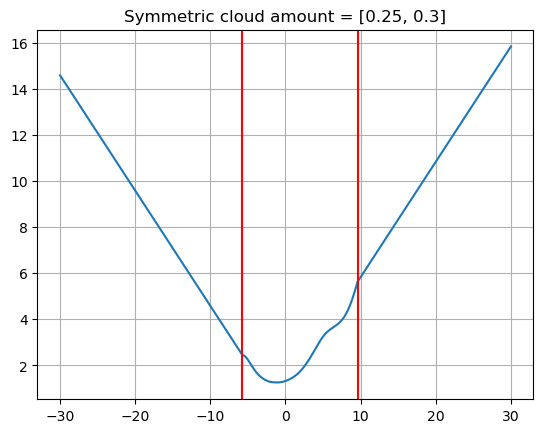

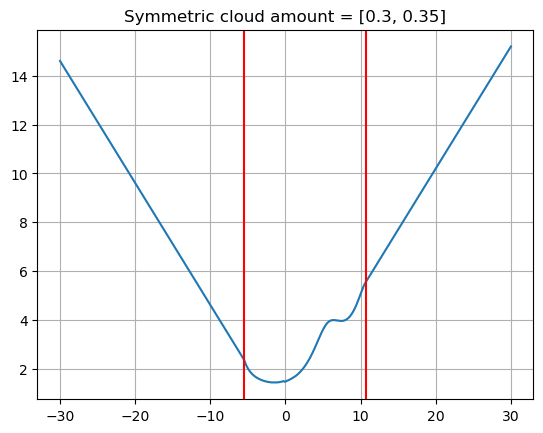

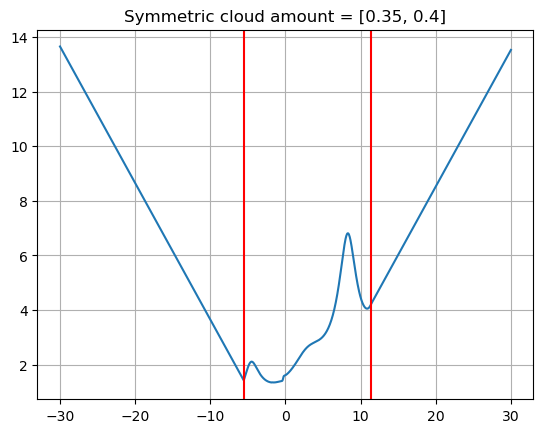

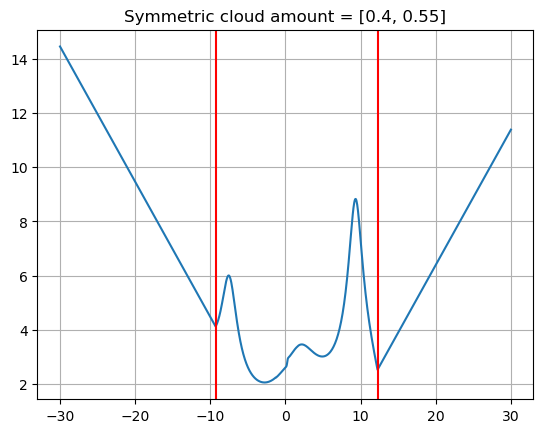

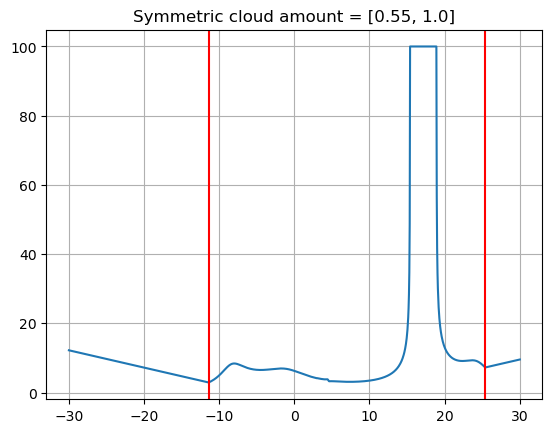

In [211]:
# check if "stdev .vs. omf" looks valid
for i in range(n_cat):
    plt.plot(regrid, nginfo[i]['record_sig'])
    plt.axvline(x=nginfo[i]['axis_omf'][nginfo[i]['range_min_idx']], color='red')
    plt.axvline(x=nginfo[i]['axis_omf'][nginfo[i]['range_max_idx']], color='red')
    #plt.xlim([-70,70])
    plt.grid(True)
    plt.title(f'Symmetric cloud amount = [{cloud_edge[i]}, {cloud_edge[i+1]}]')
    plt.show() 

In [212]:
### turn stdev into corase resolution (for the output of the table) and reconstruct the pdf based on the low-resolution stdev

for i in range(n_cat):
    dx_low_regrid = coarse_ratio*nginfo[i]['dx_omf']
    coarse_axis       = nginfo[i]['axis_omf'][::coarse_ratio].copy()
    coarse_record_sig = nginfo[i]['record_sig'][::coarse_ratio]

    # reconstruct the cost-functions:
    len_coarse_axis = len(coarse_axis)   
    tmp_recon_cost      = np.zeros(len_coarse_axis) # dummy vector
    tmp_recon_grad_cost = np.zeros(len_coarse_axis)  
    
    for j in range(len_coarse_axis):
        tmp_recon_grad_cost[j] = ( coarse_axis[j] - nginfo[i]['mode'] )/coarse_record_sig[j]**2 

    for j in range(len_coarse_axis-1):
        tmp_recon_cost[j+1] = tmp_recon_cost[j] + 0.5*(tmp_recon_grad_cost[j] + tmp_recon_grad_cost[j+1])*dx_low_regrid
    
    # reset the absoluate value of the cost function:
    recon_cost = tmp_recon_cost - np.nanmin(tmp_recon_cost) + np.nanmin(nginfo[i]['cost_fn'])
    
    nginfo[i]['coarse_axis'] = coarse_axis
    nginfo[i]['coarse_record_sig'] = coarse_record_sig
    nginfo[i]['recon_cost'] = recon_cost


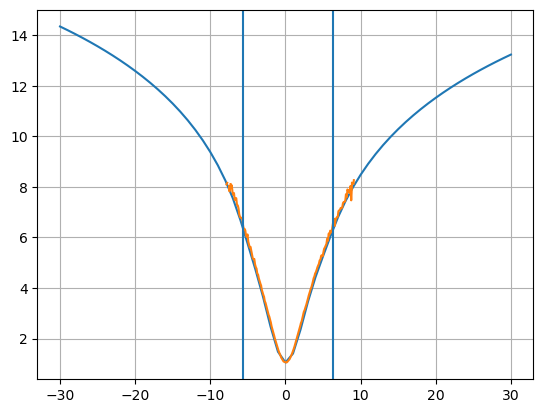

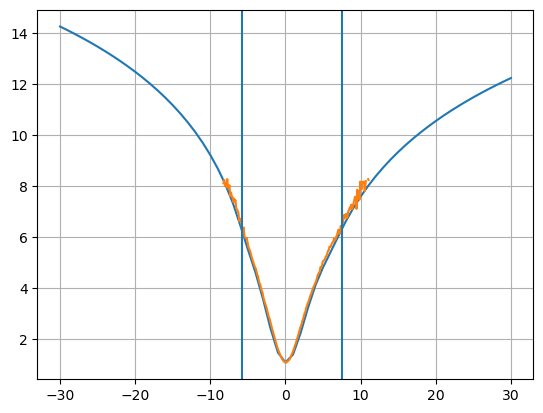

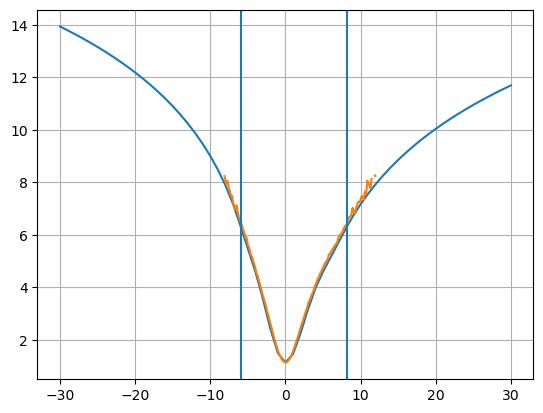

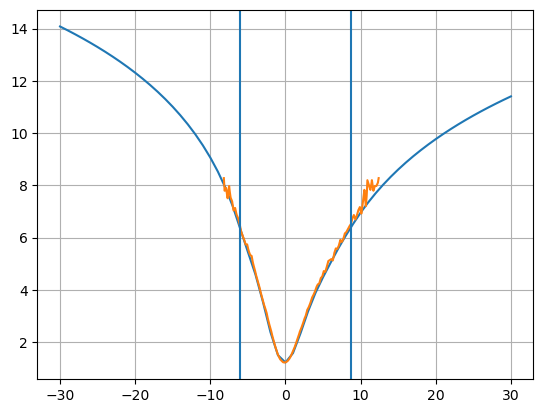

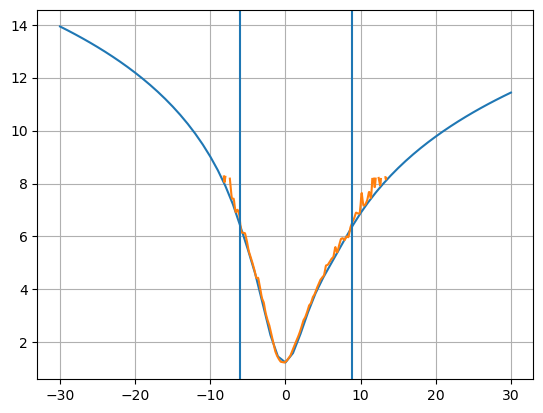

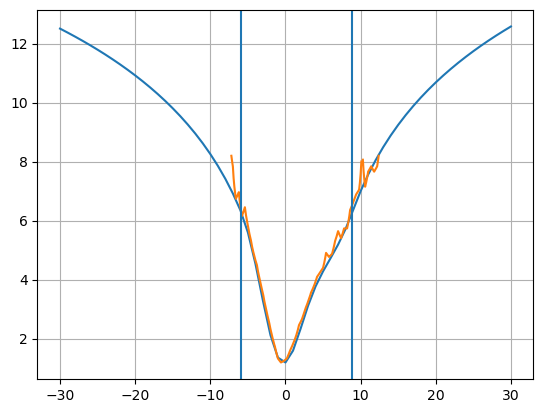

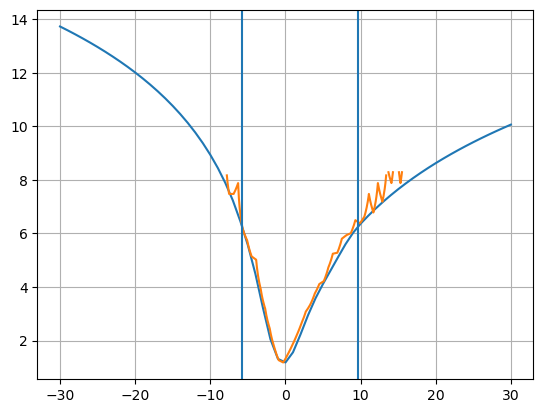

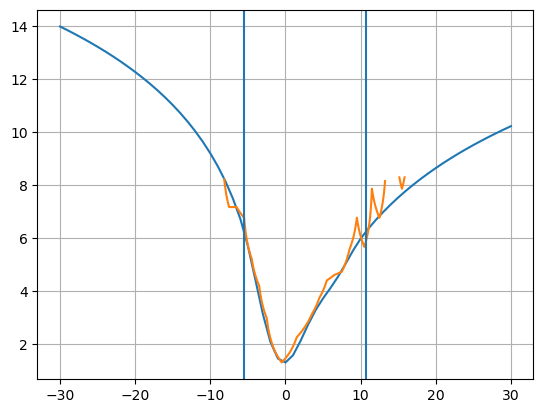

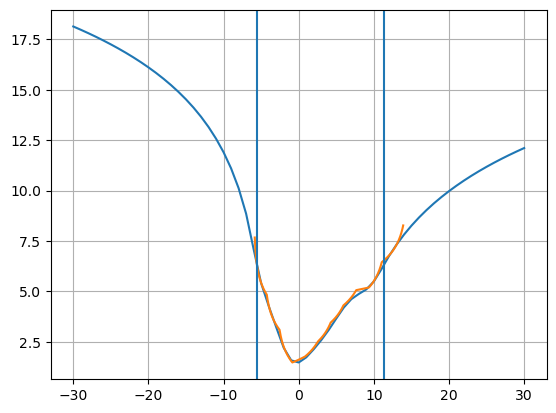

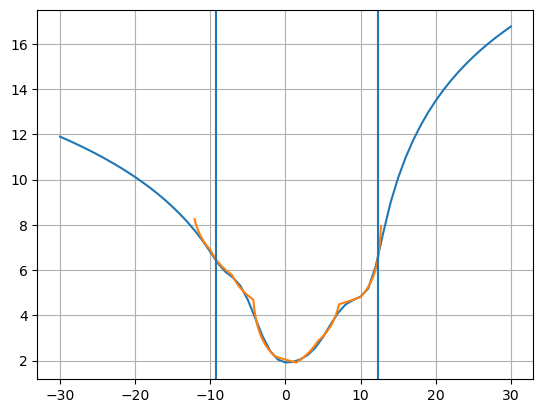

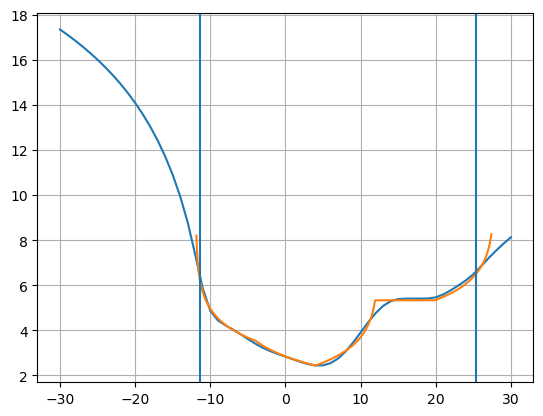

In [213]:
# check if the reconstructed cost-function is similar to the original one
#plt.plot(nginfo[7]['coarse_axis'], nginfo[7]['coarse_record_sig'])

for i in range(n_cat):
    plt.plot(nginfo[i]['coarse_axis'], nginfo[i]['recon_cost'])
    plt.plot(nginfo[i]['axis_omf'], nginfo[i]['cost_fn'])
    plt.axvline(x=nginfo[i]['axis_omf'][nginfo[i]['range_min_idx']])
    plt.axvline(x=nginfo[i]['axis_omf'][nginfo[i]['range_max_idx']])
    plt.grid(True)
    plt.show()

In [214]:
### save nginfo:
import pickle 
save_dir='/home/Chih-Chi.Hu/python_codes/tables/pkl_files'
with open(f'{save_dir}/saved_nginfo_{instrument}_{channel}_{expid}.pkl', 'wb') as f:
    pickle.dump(nginfo, f)

In [216]:
nginfo

{0: {'count': 1050237,
  'mean': 0.08802010027506386,
  'stdev': 1.4978403564861484,
  'axis_cloud': array([-0.975, -0.925, -0.875, -0.825, -0.775, -0.725, -0.675, -0.625,
         -0.575, -0.525, -0.475, -0.425, -0.375, -0.325, -0.275, -0.225,
         -0.175, -0.125, -0.075, -0.025,  0.025,  0.075,  0.125,  0.175,
          0.225,  0.275,  0.325,  0.375,  0.425,  0.475,  0.525,  0.575,
          0.625,  0.675,  0.725,  0.775,  0.825,  0.875,  0.925,  0.975,
          1.025]),
  'hist_obs_cld': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  5.40030488,
         14.5549814 ,  0.04471372,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.      

In [218]:
nginfo[10]

{'count': 26,
 'mean': 3.422409809230769,
 'stdev': 4.217269996507225,
 'axis_cloud': array([-0.975, -0.925, -0.875, -0.825, -0.775, -0.725, -0.675, -0.625,
        -0.575, -0.525, -0.475, -0.425, -0.375, -0.325, -0.275, -0.225,
        -0.175, -0.125, -0.075, -0.025,  0.025,  0.075,  0.125,  0.175,
         0.225,  0.275,  0.325,  0.375,  0.425,  0.475,  0.525,  0.575,
         0.625,  0.675,  0.725,  0.775,  0.825,  0.875,  0.925,  0.975,
         1.025]),
 'hist_obs_cld': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.76923077, 1.53846154, 3.07692308, 5.38461538, 5.38461538,
        2.30769231, 0.        , 0.76923077, 0.        , 0.        ,
        0.        , 0.        , 0.76923077, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

In [ ]:
### save the table

array_values = [float(nginfo[i]['mode']) for i in range(n_cat)]


text_head=f"""nonGaussian observation error table::
!
! only put comment (using !) in this block
!
# instrument   channel   stdev_from   predictor
#  {instrument}         {channel}        {stdev_from}        {predictor}
!
! read the parameters for the table:
! max_range     = the range of OmF pdf in x axis
! dx            = dx in x-axis to define the bin for the OmF pdf
! bdy_slope     = the slope of stdev used to extrapolate to large OmF (larger = inflating more for extreme OmF)
! cri_costfn    = define the boundry of the cost-function that are used to estimate the stdev (not used in GSI code)
! num_cloud_cat = the number of cloud amount categories
! cloud_bin     = the boundary of cloud bins (size = num_cloud_cat +1 )
!
max_range      =  {bdy_regrid:.1f}
dx             =  {coarse_ratio*dx_regrid:.2f}
bdy_slope      =  {extrap_slope}
cri_costfn     =  {10**(-critical_cost_val):.1e}
num_cloud_cat  =  {n_cat}
::

cloud_bin::
{'   '.join('{:.2f}'.format(x) for x in cloud_edge)}
::

bias::
{'   '.join('{:.2f}'.format(x) for x in array_values)}
::

stdev::
"""

#output_fn = f'non_Gaussian_{instrument}_{channel}_{stdev_from}_{predictor}_qc_00_03.txt'
output_fn =  f'test.txt'


with open(output_fn, 'w') as file:
    file.write(text_head)
    for i in range(n_cat):
        formatted_output = '   '.join('{:.2f}'.format(x) for x in nginfo[i]['coarse_record_sig'])
        file.write(formatted_output + '\n')
    file.write('::')


In [ ]:
# example to read dictionary:
with open('saved_dictionary.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)